In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder .appName("Model Training") .enableHiveSupport() .getOrCreate()

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score,precision_recall_curve,accuracy_score, f1_score, recall_score, precision_score,confusion_matrix,classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
#from pyspark.sql.functions import pandas_udf
#from pyspark.sql.types import IntegerType

In [4]:
#  Define the Hive table name
hive_table = "flight_db.flight_data_partitioned_month"

#  Read the Hive table into a Spark DataFrame
df_spark = spark.sql(f"SELECT * FROM {hive_table}")

In [5]:
# Get the unique months available in the data
months = df_spark.select("Month").distinct().collect()
print(months)
# Sample 5% data for each month
df_monthly_sampled = None

for month in months:
    month_data = df_spark.filter(df_spark.Month == month["Month"]) \
                         .sample(withReplacement=False, fraction=0.05, seed=1234)
    
    # Union the monthly sampled data
    if df_monthly_sampled is None:
        df_monthly_sampled = month_data
    else:
        df_monthly_sampled = df_monthly_sampled.union(month_data)

# Show the first 5 rows of the sampled data
df_monthly_sampled.show(5)

[Row(Month='7'), Row(Month='11'), Row(Month='3'), Row(Month='8'), Row(Month='5'), Row(Month='6'), Row(Month='9'), Row(Month='1'), Row(Month='10'), Row(Month='4'), Row(Month='12'), Row(Month='2')]
+----+-------+----------+---------+----------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+-----------------+------------------------+---------------------------+-------------------------------+---------------+------------------+------------------+------+---------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+----+---------------+---------+-------------+-------------+-------+----------+-------+--------+---------------+--------+--------------------+----------+-------+---------+--------+------+----------+-------+--------+---------------+--------+------------------+----------+---------+--------+--------------+-----------------+----

In [6]:
df=df_monthly_sampled.toPandas()

Text(0.5, 1.0, 'Correlation Matrix')

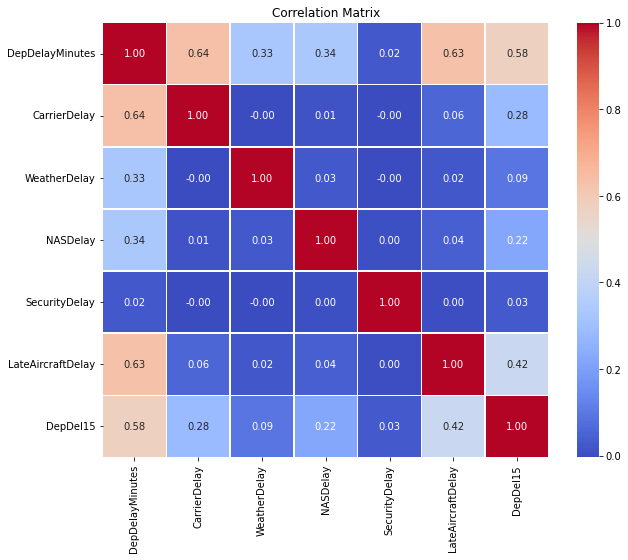

In [7]:
# Calculate correlation matrix for numerical features
correlation_matrix = df[['DepDelayMinutes', 'TaxiOut', 'TaxiIn', 'Distance', 'CarrierDelay', 
                         'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'AirTime',
                         'ActualElapsedTime', 'DepDel15']].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')

In [8]:
# Select relevant features
features = ['Month', 'DayOfWeek', 'DepTimeBlk', 'Origin', 'Dest', 'Distance', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay','TaxiOut', 'TaxiIn']
target = 'DepDel15'  # Binary classification (1 = delay >= 15 min, 0 = no delay)


In [9]:
# Separate features and target variable
X = df[features]
y = df[target].astype(int)  # Ensure binary classification

In [11]:
# Identify numerical and categorical features
num_features = ['Distance', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay','TaxiOut', 'TaxiIn']
cat_features = ['Month', 'DayOfWeek', 'DepTimeBlk', 'Origin', 'Dest']

In [12]:
# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

In [13]:
# Create pipeline with logistic regression
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter = 500))
])

In [14]:
param_grid = {
    'classifier__C': np.logspace(-4, 4, 10),  # Wider range of regularization strengths
    'classifier__solver': ['liblinear', 'saga'],  # Solvers for different dataset sizes
    'classifier__class_weight': ['balanced'],  # Handle imbalanced data
    'classifier__penalty': ['l1', 'l2']  # Regularization type (liblinear: l1, l2; saga: l1, l2)
}


In [15]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)

In [17]:
# Perform  Randomized grid search
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    cv=5,
    n_jobs=-1,
    scoring = 'recall'
)

In [18]:
random_search.fit(X_train, y_train)
# Print best parameters
print("Best Parameters:", random_search.best_params_)

Best Parameters: {'classifier__solver': 'liblinear', 'classifier__penalty': 'l2', 'classifier__class_weight': 'balanced', 'classifier__C': 0.3593813663804626}


In [19]:
# Evaluate the best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

In [20]:
# Model evaluation

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.9433
Precision: 0.8852
Recall: 0.7968
F1-score: 0.8387


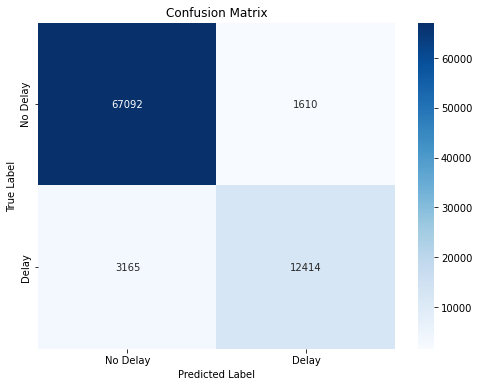

In [21]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot using Seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Delay', 'Delay'], yticklabels=['No Delay', 'Delay'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [22]:
report = classification_report(y_test, y_pred)

print('Classification Report:\n', report)

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97     68702
           1       0.89      0.80      0.84     15579

    accuracy                           0.94     84281
   macro avg       0.92      0.89      0.90     84281
weighted avg       0.94      0.94      0.94     84281



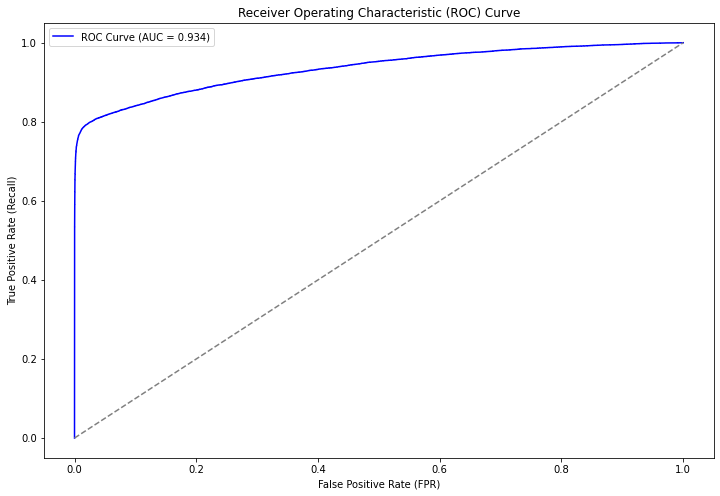

AUC Score: 0.934


In [23]:
# Get predicted probabilities (positive class)
y_probs = random_search.best_estimator_.predict_proba(X_test)[:, 1]  # Probability of class 1

# Compute ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Compute AUC Score
auc_score = roc_auc_score(y_test, y_probs)

# Plot ROC Curve
plt.figure(figsize=(12,8))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Random classifier
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

print(f"AUC Score: {auc_score:.3f}")

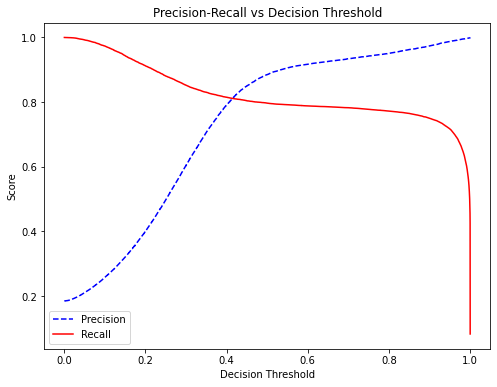

In [24]:
# Get predicted probabilities
y_probs = random_search.best_estimator_.predict_proba(X_test)[:, 1]

# Compute Precision-Recall values for different thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# Plot Precision-Recall Curve
plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'r-', label='Recall')
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision-Recall vs Decision Threshold")
plt.show()

In [25]:
# DEFAULT THRESHOLD IS 0.5
new_threshold = 0.37
y_pred_new = (y_probs >= new_threshold).astype(int)

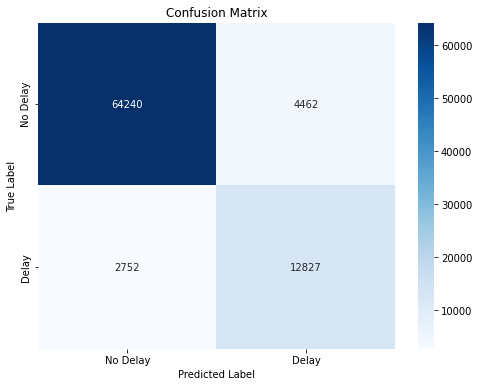

In [26]:
cm = confusion_matrix(y_test, y_pred_new)

# Plot using Seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Delay', 'Delay'], yticklabels=['No Delay', 'Delay'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [27]:
print(classification_report(y_test, y_pred_new))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95     68702
           1       0.74      0.82      0.78     15579

    accuracy                           0.91     84281
   macro avg       0.85      0.88      0.86     84281
weighted avg       0.92      0.91      0.92     84281



In [28]:
import pickle
with open('logistic_rs_model.pkl','wb') as f:
    pickle.dump(random_search,f)
    

In [41]:
from lightgbm import  LGBMClassifier
from scipy.stats import randint


In [42]:
# LightGBM pipeline with preprocessor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(random_state=24))  # LightGBM classifier
])

In [43]:
# Define the parameter grid for hyperparameter tuning
param_dist = {
    'classifier__n_estimators': randint(50, 200),  # Reduced number of estimators for faster training
    'classifier__max_depth': randint(3, 10),  # Lighter depth range
    'classifier__learning_rate': [0.01, 0.05, 0.1],  # Lighter learning rates for faster convergence
    'classifier__num_leaves': randint(20, 100),  # Lighter number of leaves
    'classifier__subsample': [0.7, 0.8, 0.9],  # Subsample for regularization
    'classifier__colsample_bytree': [0.7, 0.8],  # Column subsample for reducing overfitting
}

In [44]:
random_search1 = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=30,
    cv=3,
    scoring='recall',
    n_jobs=-1,
    random_state=24,
    verbose=2
)

In [45]:
random_search1.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['Distance',
                                                                                'CarrierDelay',
                                                                                'WeatherDelay',
                                                                                'NASDelay',
                                                                                'SecurityDelay',
                                                                                'LateAircraftDelay',
                                                                                'TaxiOut',
                                                                 

In [52]:
# Get the best model
best_lgbm = random_search1.best_estimator_
# Make predictions on the test set
y_pred = best_lgbm.predict(X_test)

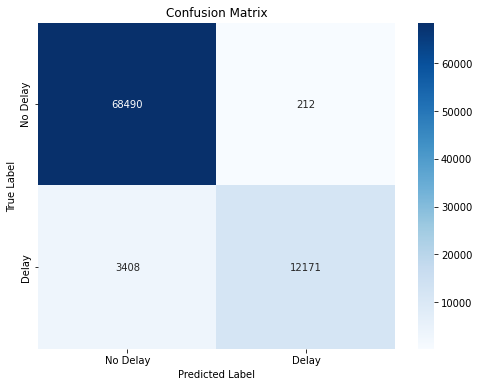

In [53]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot using Seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Delay', 'Delay'], yticklabels=['No Delay', 'Delay'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [54]:
# Model evaluation

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.9570
Precision: 0.9829
Recall: 0.7812
F1-score: 0.8705


In [55]:
report = classification_report(y_test, y_pred)

print('Classification Report:\n', report)

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97     68702
           1       0.98      0.78      0.87     15579

    accuracy                           0.96     84281
   macro avg       0.97      0.89      0.92     84281
weighted avg       0.96      0.96      0.96     84281



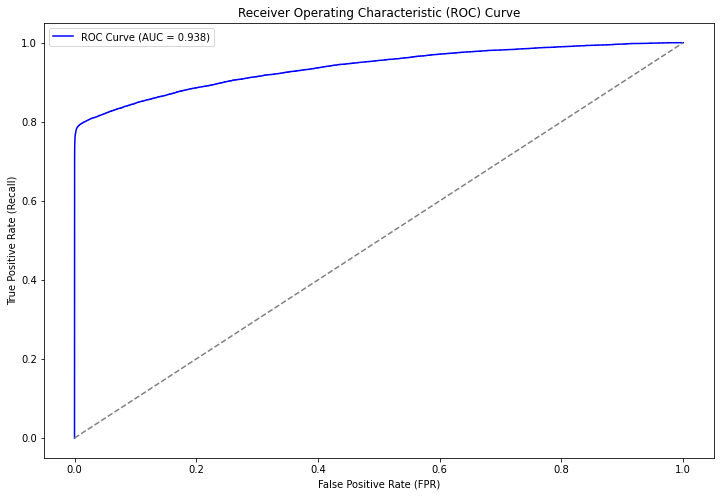

AUC Score: 0.938


In [56]:
# Get predicted probabilities (positive class)
y_probs = random_search1.best_estimator_.predict_proba(X_test)[:, 1]  # Probability of class 1

# Compute ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Compute AUC Score
auc_score = roc_auc_score(y_test, y_probs)

# Plot ROC Curve
plt.figure(figsize=(12,8))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Random classifier
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

print(f"AUC Score: {auc_score:.3f}")

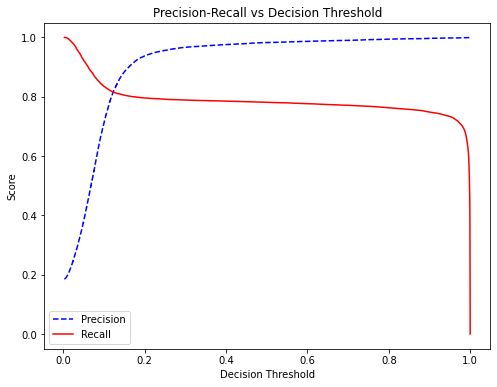

In [57]:
# Get predicted probabilities
y_probs = random_search1.best_estimator_.predict_proba(X_test)[:, 1]

# Compute Precision-Recall values for different thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# Plot Precision-Recall Curve
plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'r-', label='Recall')
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision-Recall vs Decision Threshold")
plt.show()

In [58]:
# DEFAULT THRESHOLD IS 0.5
new_threshold = 0.1
y_pred_new = (y_probs >= new_threshold).astype(int)

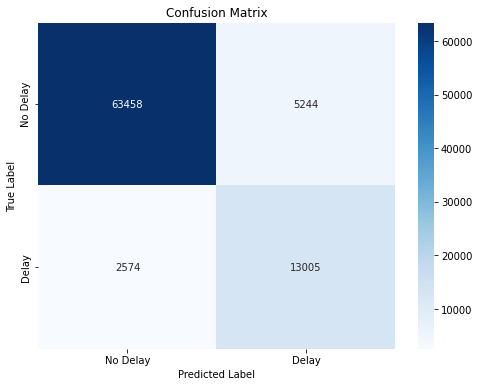

In [59]:
cm = confusion_matrix(y_test, y_pred_new)

# Plot using Seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Delay', 'Delay'], yticklabels=['No Delay', 'Delay'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [60]:
print(classification_report(y_test, y_pred_new))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94     68702
           1       0.71      0.83      0.77     15579

    accuracy                           0.91     84281
   macro avg       0.84      0.88      0.86     84281
weighted avg       0.92      0.91      0.91     84281



In [49]:
# Save the trained model (best_rf in this case) to a file
with open('./best_lgbm_model.pkl', 'wb') as f:
    pickle.dump(random_search1, f)

print("Model saved as 'best_lgbm_model.pkl'")

Model saved as 'best_lgbm_model.pkl'


In [61]:
spark.stop()